<img src='../../images/wcd_logo.png' width='50%'>

# Lab: Build a Traffic Sign Recognition Classifier using KNN and SVM



In this lab, you will build pipelines to classify the traffic signs from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The project is explained in the following sections.

- Data Exploratory Analysis
- Image processing and feature extraction
- Model Implementation
- Testing and Results

# Data Exploratory Analysis

The traffic sign images were taken from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). You need to download the data for this lab from Google Drive.



## Training Data Folder Structure

The training images are organized in folders by category.  Each folder is meant for one category (i.e. stop sign) and has a label file (.csv) which is actually semi-colon delimited (not comma delimited).

```
data
 + Final_Training
    + Images
        + 00000
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00000.csv
        + 00001
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00001.csv
        ...
```

All images are stored in the PPM format ([Portable Pixmap, P6](http://en.wikipedia.org/wiki/Netpbm_format)).  You'll need to install both `matplotlib` and `pillow` to handle such image format.  If you use one of the evironments yml files in this repository, this will be taken care of.

## Import Required Libraries

In [319]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Loading Training Data

All train image paths are combined into one dataframe for convenience.

In [320]:
TRAIN_IMAGE_DIR = '.\\dataset\\training\\Images' 

dfs = []
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*\\GT-*.csv')):
    #print(train_file)
    folder = '\\'.join(train_file.split('\\')[:-1])
    #print(folder)
    df = pd.read_csv(train_file, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join( folder, x))
    #print(df['Filename'][0])
    dfs.append(df)

In [321]:
train_df = pd.concat(dfs, ignore_index=True)
train_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,.\dataset\training\Images\00001\00000_00000.ppm,56,57,6,5,51,52,1
1,.\dataset\training\Images\00001\00000_00001.ppm,55,57,5,6,50,52,1
2,.\dataset\training\Images\00001\00000_00002.ppm,56,56,5,6,51,51,1
3,.\dataset\training\Images\00001\00000_00003.ppm,58,58,6,6,53,52,1
4,.\dataset\training\Images\00001\00000_00004.ppm,59,59,6,6,54,53,1


**Annotation format**
- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box
- ClassId: Assigned class label

The following points are worth mentioning:
- Image sizes are not fixed
- Sign sizes are not fixed
- Sign's center location is not fixed

Later on, we'll examine sample images to further clarify those points.

## Class Distribution

There are 4 traffic sign classes in 4350 training images. (There are actually 43 traffic sign classes in the German Traffic Sign Benchmarks. Given limited time in this open class, for shorter training time, we pick only 4 classes.)

In [142]:
N_CLASSES = np.unique(train_df['ClassId']).size  # keep this for later

print("Number of training images : {:>5}".format(train_df.shape[0]))
print("Number of classes         : {:>5}".format(N_CLASSES))

Number of training images :  4350
Number of classes         :     4


The name of each sign are stored in signnames_4classes.csv file.  We can use it see the distribution per sign names.

In [143]:
sign_name_df = pd.read_csv('signnames_4classes.csv', index_col='ClassId')
sign_name_df.head()

,SignName
ClassId,
1,Speed limit (30km/h)
14,Stop
17,No entry
27,Pedestrians


In [144]:
sign_name_df['Occurence'] = [sum(train_df['ClassId']==c) for c in [1, 14, 17, 27]]
sign_name_df.sort_values('Occurence', ascending=False)

,SignName,Occurence
ClassId,,
1,Speed limit (30km/h),2220
17,No entry,1110
14,Stop,780
27,Pedestrians,240


The following constant is defined for later use.

In [145]:
SIGN_NAMES = sign_name_df.SignName.values
SIGN_NAMES[0], SIGN_NAMES[1], SIGN_NAMES[2], SIGN_NAMES[3]

('Speed limit (30km/h)', 'Stop', 'No entry', 'Pedestrians')

## Sample Images

Let's examine some random images:

In [72]:
def load_image(image_file):
    """
    Read image file into numpy array (RGB)
    """
    return plt.imread(image_file)

In [73]:
def get_samples(image_data, num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Filename', 'ClassId']].values

In [161]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
            
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

The below are 10 random sample images from the train set.

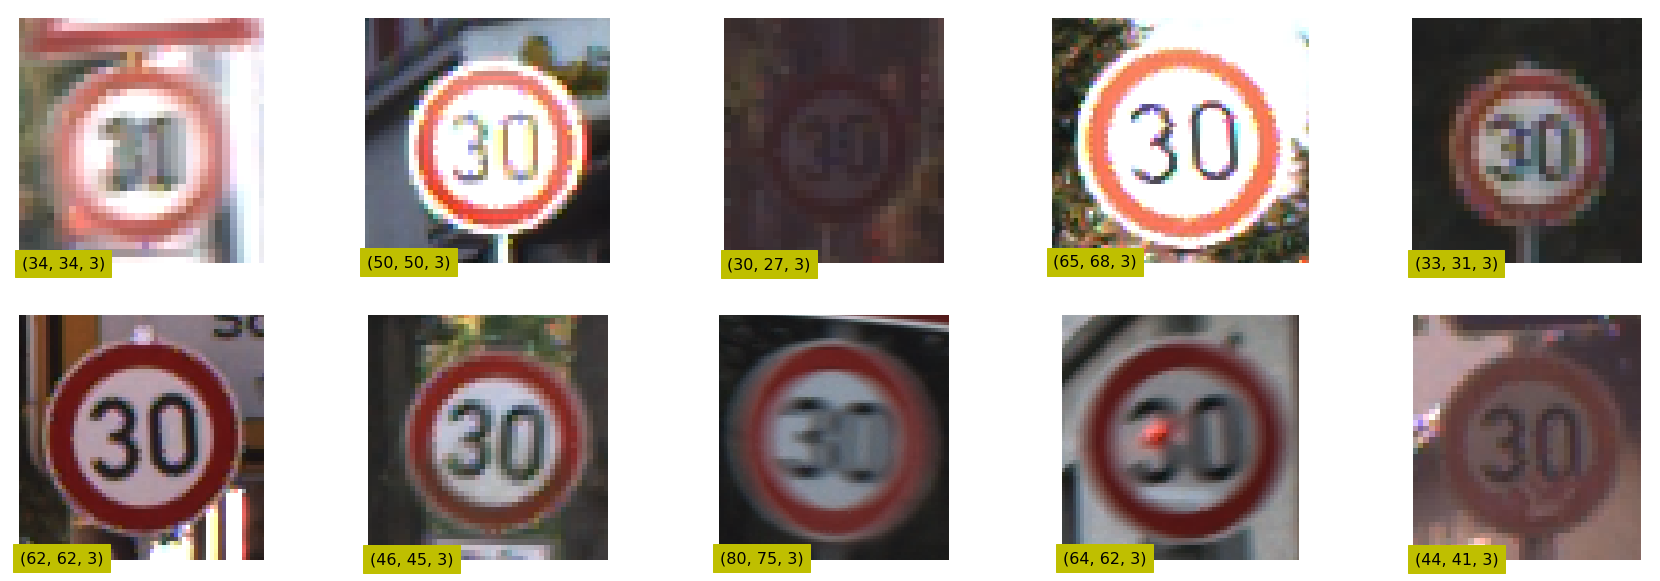

In [162]:
sample_data = get_samples(train_df, 10, 1)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

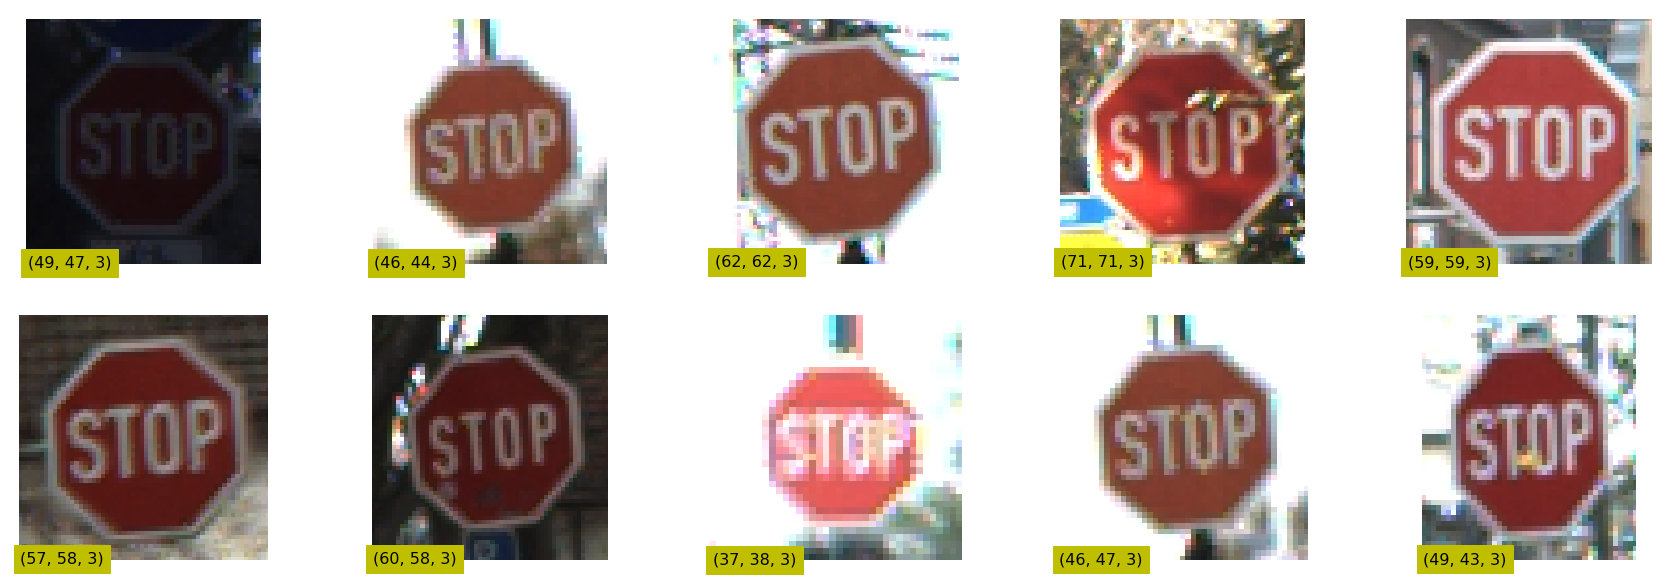

In [163]:
sample_data = get_samples(train_df, 10, 14)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

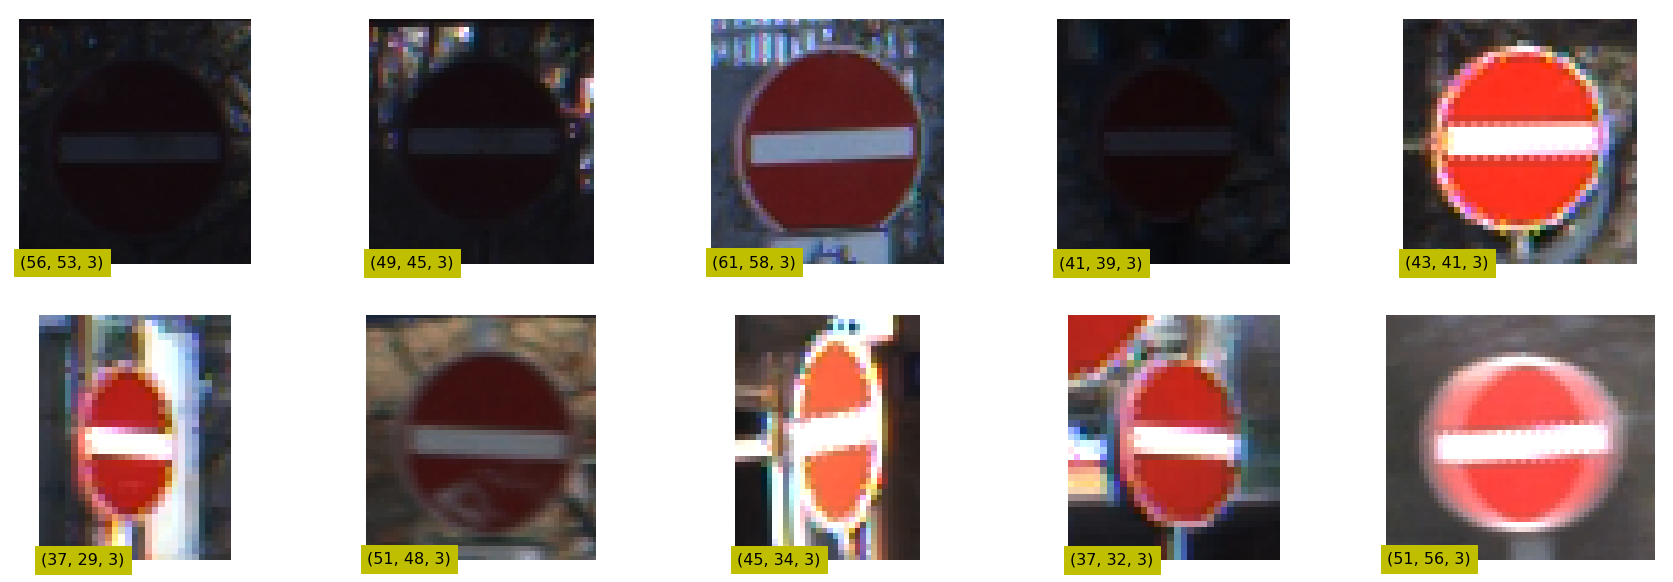

In [164]:
sample_data = get_samples(train_df, 10, 17)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

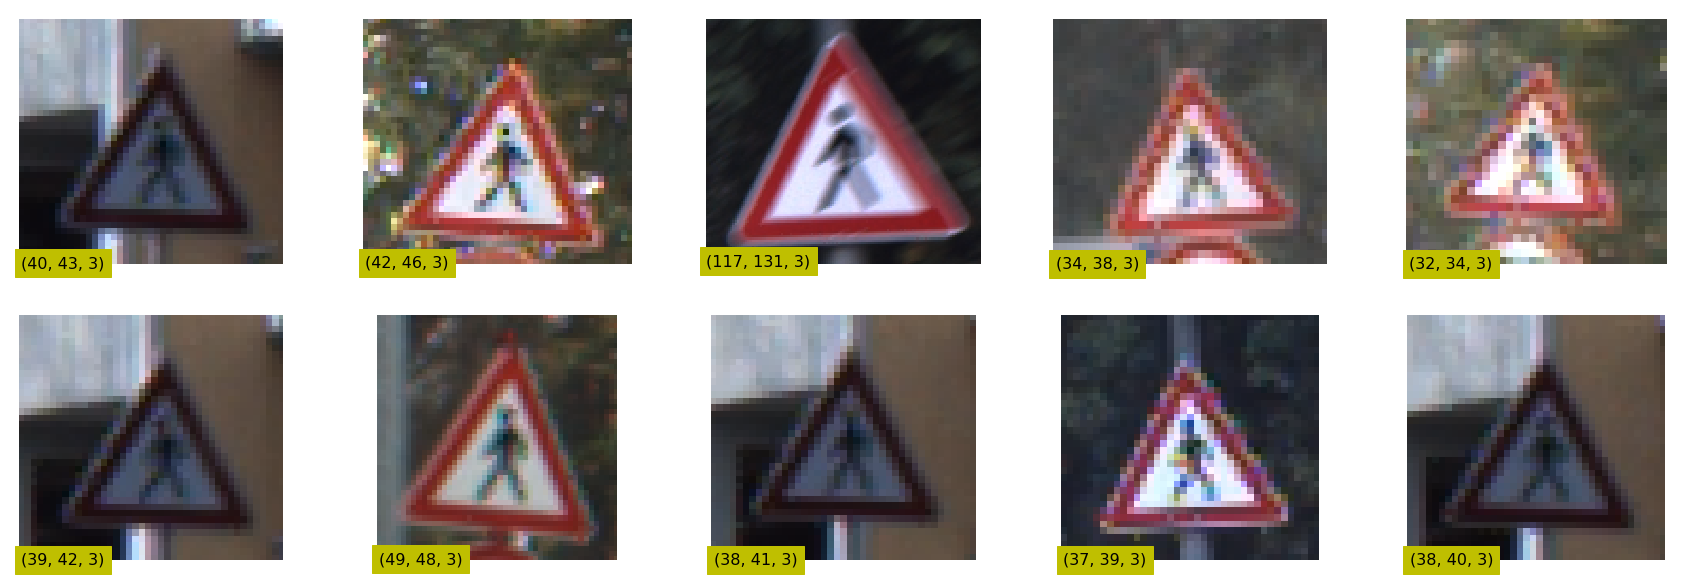

In [165]:
sample_data = get_samples(train_df, 10, 27)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

Looking at the sample images, the following image characteristics are confirmed:

- The images comes in different sizes  
- The darkness / brightness of those images are fairly random
- The images may be slightly rotated
- The images may not be facing straight
- The images may not be exactly centered
  


## Feature Extraction, Training and Validation Data Split

Train and validation data set are created from the training data.

Image features are extracted using Opencv.

[Windows Install OpenCV 3.3 in Python 3.6 / 2.7](https://www.scivision.co/install-opencv-python-windows/)

In [173]:
train_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,.\dataset\training\Images\00001\00000_00000.ppm,56,57,6,5,51,52,1
1,.\dataset\training\Images\00001\00000_00001.ppm,55,57,5,6,50,52,1
2,.\dataset\training\Images\00001\00000_00002.ppm,56,56,5,6,51,51,1
3,.\dataset\training\Images\00001\00000_00003.ppm,58,58,6,6,53,52,1
4,.\dataset\training\Images\00001\00000_00004.ppm,59,59,6,6,54,53,1


In [246]:
import cv2
from skimage.feature import hog
from scipy.misc import imread

In [252]:
'''
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   transform_sqrt=True, 
                   feature_vector=feature_vec)
    return features
'''

In [323]:
def _extract_feature(X, feature):
    """Performs feature extraction

        :param X:       data (rows=images, cols=pixels)
        :param feature: which feature to extract
                        - None:   no feature is extracted
                        - "gray": grayscale features
                        - "rgb":  RGB features
                        - "hsv":  HSV features
                        - "hog":  HOG features
        :returns:       X (rows=samples, cols=features)
    """

    # transform color space
    if feature == 'gray':
        X = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X]
    elif feature == 'hsv':
        X = [cv2.cvtColor(x, cv2.COLOR_BGR2HSV) for x in X]

    # operate on smaller image
    small_size = (32, 32)
    X = [cv2.resize(x, small_size) for x in X]
    
    # extract features
        
    if feature == 'hog':
        
        # histogram of gradients
        block_size = (small_size[0] // 2, small_size[1] // 2)
        block_stride = (small_size[0] // 4, small_size[1] // 4)
        cell_size = block_stride
        num_bins = 9
        hog = cv2.HOGDescriptor(small_size, block_size, block_stride,
                                cell_size, num_bins)
        X = [hog.compute(x) for x in X]
           
    elif feature is not None:
        # normalize all intensities to be between 0 and 1
        X = np.array(X).astype(np.float32) / 255

        # subtract mean
        X = [x - np.mean(x) for x in X]

    X = [x.flatten() for x in X]
    
    return X

In [324]:
def load_data(data, feature=None, cut_roi=False,
              test_split=0.2, plot_samples=False, seed=113):
    """Loads the GTSRB dataset
        This function loads the German Traffic Sign Recognition Benchmark
        (GTSRB), performs feature extraction, and partitions the data into
        mutually exclusive training and test sets.
        
        :param feature:      which feature to extract: None, "gray", "rgb",
                             "hsv", surf", or "hog"
        :param cut_roi:      flag whether to remove regions surrounding the
                             actual traffic sign (True) or not (False)
        :param test_split:   fraction of samples to reserve for the test set
        :param plot_samples: flag whether to plot samples (True) or not
                             (False)
        :param seed:         which random seed to use
        :returns:            (X_train, y_train), (X_test, y_test)
    """
    
    # read all training samples and corresponding class labels
    X = []  # data
    labels = []  # corresponding labels
    for c in range(len(data)):
        im = imread(data['Filename'].values[c])
        # first column is filename
        # im = cv2.imread(data['Filename'].value[c])

        # remove regions surrounding the actual traffic sign
        if cut_roi:
            im = im[np.int(data['Roi.X1'].values[c]):np.int(data['Roi.X2'].values[c]),
                    np.int(data['Roi.Y1'].values[c]):np.int(data['Roi.Y2'].values[c]), :]

        X.append(im)
        labels.append(data['ClassId'].values[c])
        

    # perform feature extraction
    X = _extract_feature(X, feature)

    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(labels)

    if plot_samples:
        num_samples = 15
        sample_idx = np.random.randint(len(X), size=num_samples)
        sp = 1
        for r in xrange(3):
            for c in xrange(5):
                ax = plt.subplot(3, 5, sp)
                sample = X[sample_idx[sp - 1]]
                ax.imshow(sample.reshape((32, 32)), cmap=cm.Greys_r)
                ax.axis('off')
                sp += 1
        plt.show()

    X_train = X[:int(len(X)*(1-test_split))]
    y_train = labels[:int(len(X)*(1-test_split))]

    X_test = X[int(len(X)*(1-test_split)):]
    y_test = labels[int(len(X)*(1-test_split)):]

    return (X_train, y_train), (X_test, y_test)
    

In [325]:
(X_train, y_train), (X_valid, y_valid) = load_data(train_df, feature='hog', 
                                                   cut_roi=False, test_split=0.2, plot_samples=False, seed=113)

(X_train_gray, y_train_gray), (X_valid_gray, y_valid_gray) = load_data(train_df, feature='gray', 
                                                   cut_roi=False, test_split=0.2, plot_samples=False, seed=113)

(X_train_hsv, y_train_hsv), (X_valid_hsv, y_valid_hsv) = load_data(train_df, feature='hsv', 
                                                   cut_roi=False, test_split=0.2, plot_samples=False, seed=113)

(X_train_rgb, y_train_rgb), (X_valid_rgb, y_valid_rgb) = load_data(train_df, feature='rgb', 
                                                   cut_roi=False, test_split=0.2, plot_samples=False, seed=113)


print('X_train:', len(X_train))
print('X_valid:', len(X_valid))

X_train: 3480
X_valid: 870


In [281]:
import time
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [288]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_valid, y_valid), 4))

0.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9977


In [289]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
t=time.time()
neigh1.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train KNN...')
print('Test Accuracy of KNN = ', round(neigh1.score(X_valid, y_valid), 4))

0.07 Seconds to train KNN...
Test Accuracy of KNN =  0.9989


In [326]:
neigh1_gray = KNeighborsClassifier(n_neighbors=1)
t=time.time()
neigh1_gray.fit(X_train_gray, y_train_gray)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train KNN using gray image feature ...')
print('Test Accuracy of KNN = ', round(neigh1_gray.score(X_valid_gray, y_valid_gray), 4))

0.33 Seconds to train KNN using gray image feature ...
Test Accuracy of KNN =  0.977


## Try other image feature and machine learning classification methods 

Write your code below using 'rgb' features or 'hsv' features.

Try the following machine learning methods;

- [KNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): you may change the number of 'k'
- [SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Decision trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [329]:
'''
neigh1_rgb = KNeighborsClassifier(n_neighbors=1)
t=time.time()
neigh1_rgb.fit(X_train_rgb, y_train_rgb)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train KNN using rgb image feature ...')
print('Test Accuracy of KNN = ', round(neigh1_rgb.score(X_valid_rgb, y_valid_rgb), 4))
'''

0.97 Seconds to train KNN using rgb image feature ...
Test Accuracy of KNN =  0.9793


In [330]:
"""
neigh1_hsv = KNeighborsClassifier(n_neighbors=1)
t=time.time()
neigh1_hsv.fit(X_train_hsv, y_train_hsv)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train KNN using hsv image feature ...')
print('Test Accuracy of KNN = ', round(neigh1_hsv.score(X_valid_hsv, y_valid_hsv), 4))
"""

0.94 Seconds to train KNN using rgb image feature ...
Test Accuracy of KNN =  0.9966


In [217]:
'''
neigh2 = KNeighborsClassifier(n_neighbors=2)
t=time.time()
neigh2.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train KNN...')
print('Test Accuracy of KNN = ', round(neigh2.score(X_valid, y_valid), 4))
'''

0.09 Seconds to train KNN...
Test Accuracy of KNN =  0.9977


-----

## Testing

In [232]:
sign_name_df.head()

,SignName,Occurence
ClassId,,
1,Speed limit (30km/h),2220
14,Stop,780
17,No entry,1110
27,Pedestrians,240


In [331]:
X=[]
im = imread('./dataset/testing/00031.ppm')
X.append(im)
X = _extract_feature(X, 'hog')

print('Sign pridiction class ID: ', neigh1.predict(X))
print('Sign pridiction class ID: ',svc.predict(X))

Sign pridiction class ID:  [17]
Sign pridiction class ID:  [17]


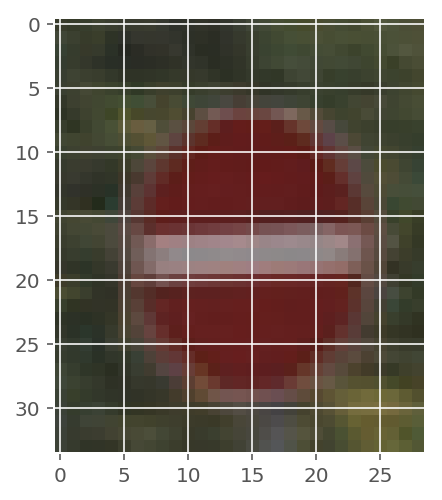

In [301]:
plt.imshow(im)

[17]
[17]


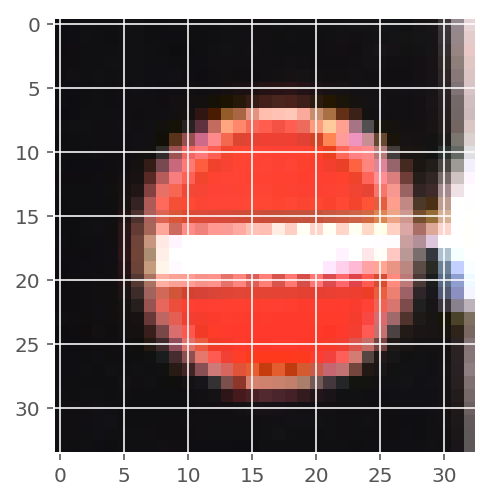

In [305]:
X=[]
img_test = imread('./dataset/testing/00035.ppm')
X.append(img_test)
X = _extract_feature(X, 'hog')
plt.imshow(img_test)
print('Sign pridiction: ', neigh1.predict(X))
print('Sign pridiction: ',svc.predict(X))

[14]
[14]


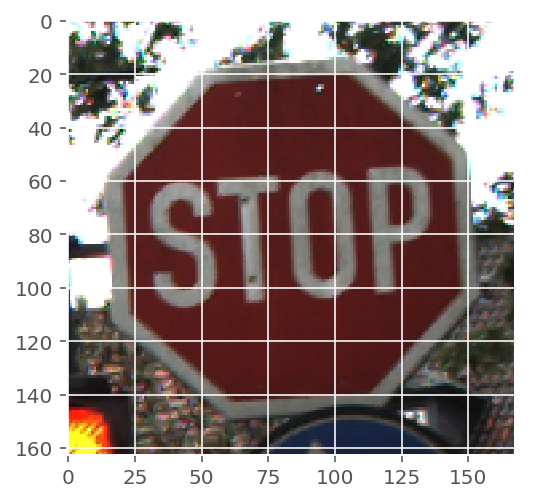

In [306]:
X=[]
img_test = imread('./dataset/testing/00251.ppm')
X.append(img_test)
X = _extract_feature(X, 'hog')
plt.imshow(img_test)
print('Sign pridiction: ', neigh1.predict(X))
print('Sign pridiction: ',svc.predict(X))

Sign pridiction:  [14]
Sign pridiction:  [14]


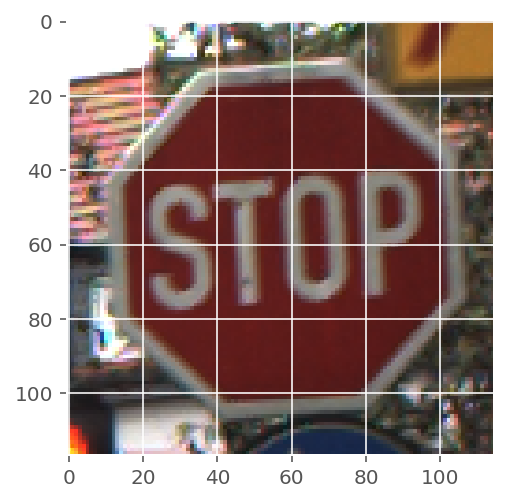

In [318]:
X=[]
img_test = imread('./dataset/testing/00224.ppm')
X.append(img_test)
X = _extract_feature(X, 'hog')
plt.imshow(img_test)
print('Sign pridiction: ', neigh1.predict(X))
print('Sign pridiction: ', svc.predict(X))

Sign pridiction:  [1]
Sign pridiction:  [1]


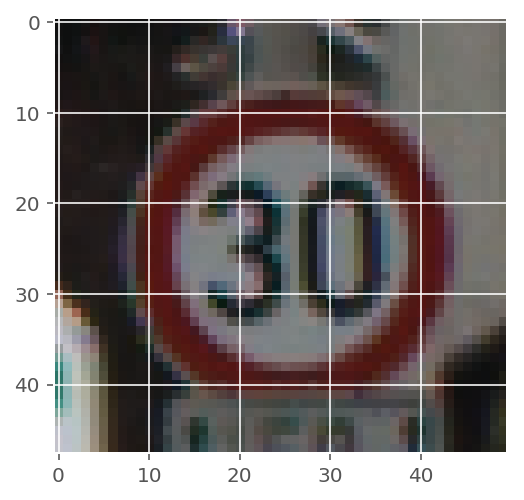

In [314]:
X=[]
img_test = imread('./dataset/testing/00128.ppm')
X.append(img_test)
X = _extract_feature(X, 'hog')
plt.imshow(img_test)
print('Sign pridiction: ', neigh1.predict(X))
print('Sign pridiction: ',svc.predict(X))

Sign pridiction:  [1]
Sign pridiction:  [1]


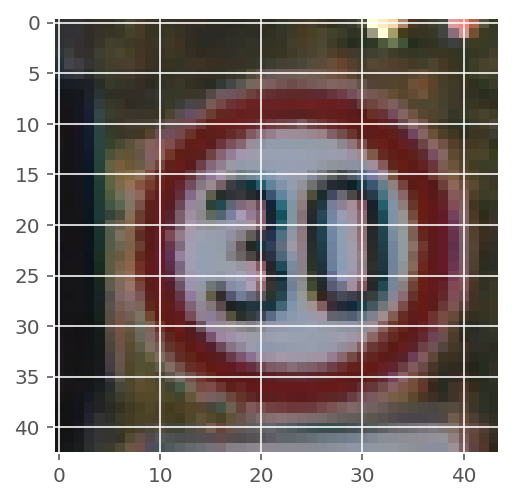

In [316]:
X=[]
img_test = imread('./dataset/testing/00223.ppm')
X.append(img_test)
X = _extract_feature(X, 'hog')
plt.imshow(img_test)
print('Sign pridiction: ', neigh1.predict(X))
print('Sign pridiction: ',svc.predict(X))


Sign pridiction:  [27]
Sign pridiction:  [27]


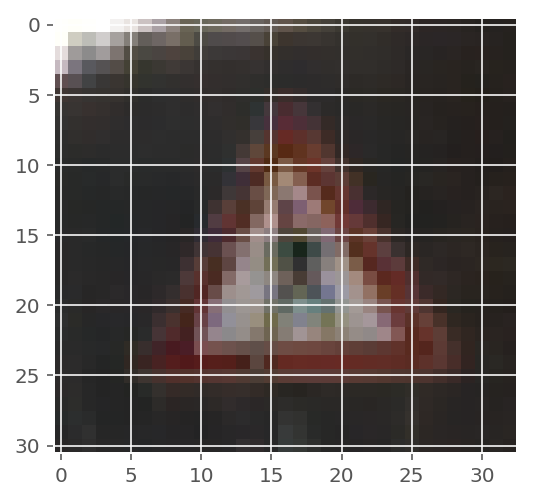

In [317]:
X=[]
img_test = imread('./dataset/testing/00116.ppm')
X.append(img_test)
X = _extract_feature(X, 'hog')
plt.imshow(img_test)
print('Sign pridiction: ', neigh1.predict(X))
print('Sign pridiction: ',svc.predict(X))